# 2조 Project 5:  중합공정이상원인파악
### 안상후, 정아영

In [2]:
# 필요한 패키지 불러오기 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.metrics import geometric_mean_score
from scipy.stats import boxcox
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import optuna
from optuna.samplers import TPESampler
from sklearn.utils import resample
from scipy.stats import chi2_contingency
import seaborn as sns
import itertools
from scipy.signal import correlate
import statsmodels.api as sm
from matplotlib.dates import DateFormatter, MinuteLocator
from statsmodels.stats.outliers_influence import variance_inflation_factor


## 색조 L치

데이터 불러오기

In [3]:
# 랜덤시드 설정 및 데이터 불러오기 
np.random.seed(42)

b1 = pd.read_excel("./중합 CPS-8 DB B1.xlsx")
b2 = pd.read_excel("./중합 CPS-8 DB B2.xlsx")
b1.shape
b2.shape

(43201, 213)

데이터 merge 및 중복행 제거 

In [4]:
df_b = pd.merge(b1, b2, on = 'Timestamp', how = 'inner')
df_b = df_b.drop_duplicates(keep='first')
df_b.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43201 entries, 0 to 43200
Columns: 411 entries, Timestamp to LAB_8CHIP_SIZE - Average
dtypes: datetime64[ns](1), float64(407), int64(3)
memory usage: 135.8 MB


고유값이 1인 열 제거 

In [5]:
df_b=  df_b.loc[:, df_b.nunique() != 1]

이상 발생 시점 시각화

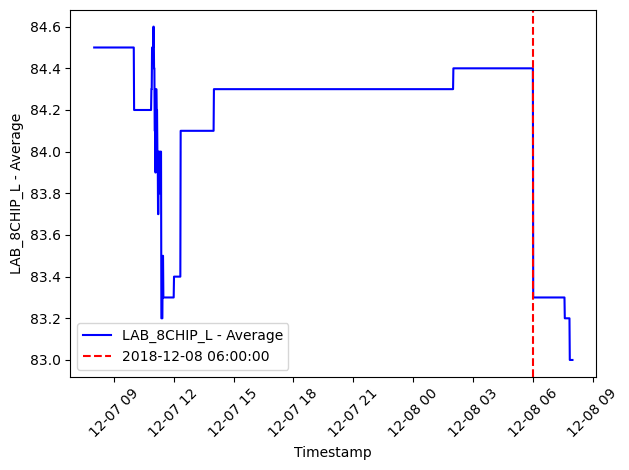

In [6]:
# 이상 발생 시점이 2018-12-08 6:00:00
sns.lineplot(data=df_b[(df_b['Timestamp'] > '2018-12-07 08:00:00') & (df_b['Timestamp'] < '2018-12-08 08:00:00')],
             x='Timestamp', y='LAB_8CHIP_L - Average', label='LAB_8CHIP_L - Average', color='blue')
plt.axvline(pd.to_datetime('2018-12-08 06:00:00'), color='red', linestyle='--', label='2018-12-08 06:00:00')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

**교차상관분석**
* 분석기간: 이상이 발생한 일주일 전 시점인 12-01 06:00:00부터
* 중합공정의 사이클을 하루로 가정함. 최대 lag 값을 2880로 이틀만 고려함. 
* 교차상관관계가 가장 높은 10개의 변수와 그 때의 lag 값 출력

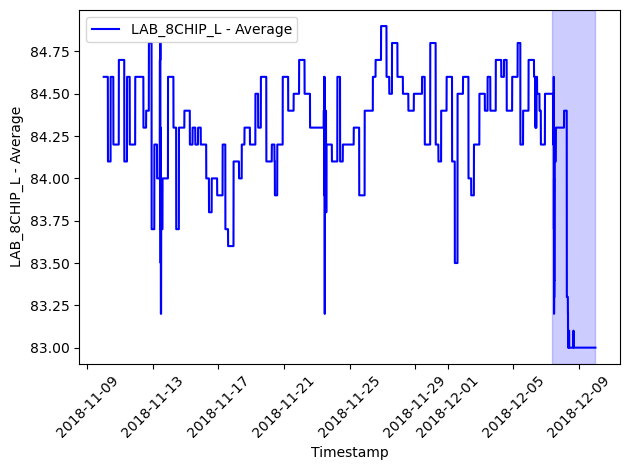

c:\Users\USER\DS\Miniconda\envs\ls_env\Lib\site-packages\statsmodels\tsa\stattools.py:1168: RuntimeWarning: invalid value encountered in divide
  ret = cvf / (np.std(x) * np.std(y))


Variable  Max Cross-correlation  Lag at Max
332   8II_E9130A.PV - Average               0.868289         562
38    8TI_R4260C.PV - Average               0.867289         123
77   8TIC_E9221A.PV - Average               0.865893           0
39    8TI_R4260D.PV - Average               0.855446         126
18     8TI_D4250.PV - Average               0.853980           0
388   8TI_R9330B.PV - Average               0.853655           0
304   8TI_E9261A.PV - Average               0.853320           1
94     8PI_F4272.PV - Average               0.850018           0
14     8TI_D4240.PV - Average               0.849493           0
395   8TI_E9330D.PV - Average               0.847948           0

In [7]:
# 분석기간 일주일
filtered_df_b = df_b[df_b['Timestamp'] >= '2018-12-01 06:00:00']

sns.lineplot(data=df_b, x='Timestamp', y='LAB_8CHIP_L - Average', label='LAB_8CHIP_L - Average', color='blue')
highlight_start = pd.to_datetime('2018-12-07 08:00:00')
highlight_end = filtered_df_b['Timestamp'].max()
plt.axvspan(highlight_start, highlight_end, color='blue', alpha=0.2)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

filtered_df_b = df_b[df_b['Timestamp'] >= '2018-12-01 06:00:00']


# 교차상관분석 함수
def calculate_top_cross_correlations(df, target_column, max_lags=2880, top_n=20):
    # 데이터 프레임에서 타겟 변수 선택
    target = df[target_column]

    # 결과를 저장할 리스트 초기화
    cross_correlations = []

    # DataFrame의 모든 컬럼을 순회하면서 타겟 변수와의 교차상관 계산
    for column in df.columns:
        if column != target_column:  # 타겟 변수 제외
            # 교차상관 계산 (타겟 변수가 먼저, 다른 변수들이 lag됨)
            cc = sm.tsa.stattools.ccf(target, df[column], adjusted=False)[:max_lags]
            max_cc = np.max(np.abs(cc))  # 최대 상관계수(절대값) 추출
            lag_at_max = np.argmax(np.abs(cc))  # 최대값이 발생하는 lag (양수 lag)
            # 각 결과 저장
            cross_correlations.append((column, max_cc, lag_at_max))

    # 결과를 데이터 프레임으로 변환
    cc_df = pd.DataFrame(cross_correlations, columns=['Variable', 'Max Cross-correlation', 'Lag at Max'])

    # 상관계수가 높은 상위 N개 결과 정렬 및 선택
    top_results = cc_df.sort_values(by='Max Cross-correlation', ascending=False).head(top_n)

    return top_results

b_top_10 = calculate_top_cross_correlations(filtered_df_b, 'LAB_8CHIP_L - Average', max_lags=2880, top_n=10)
b_top_10


교차상관관계 top10 변수 중 Lag at Max > 0인 변수 시각화

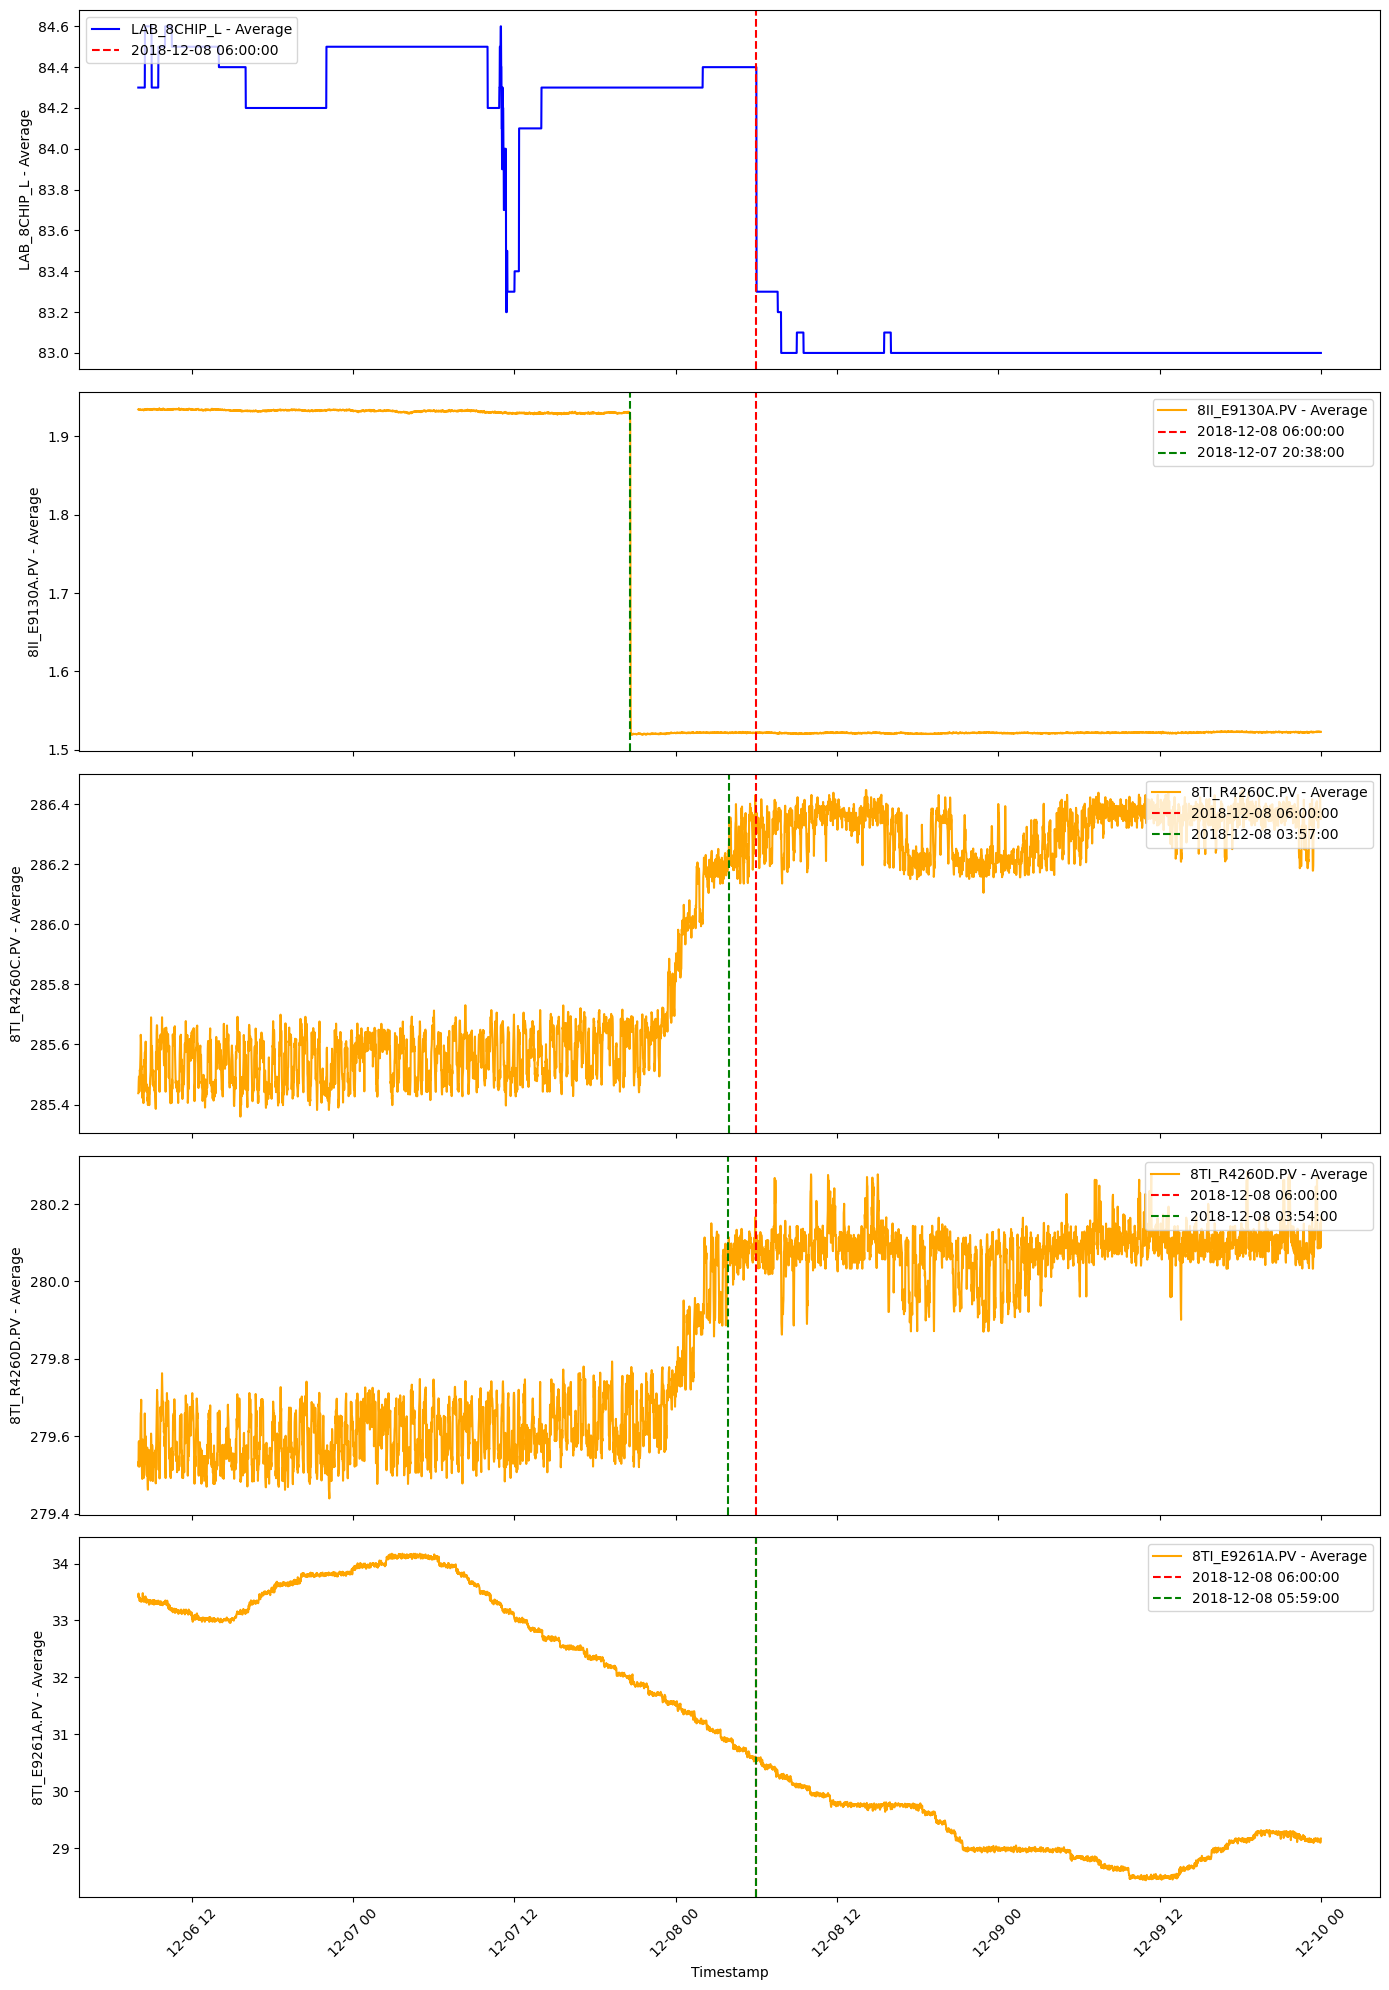

In [8]:
# 서브플롯 생성
fig, axes = plt.subplots(5, 1, figsize=(14, 20), sharex=True)

# LAB_8CHIP_L - Average 그래프
sns.lineplot(data=df_b[df_b['Timestamp'] > '2018-12-06 08:00:00'],
 x='Timestamp', y='LAB_8CHIP_L - Average', ax=axes[0], color='blue', label='LAB_8CHIP_L - Average')
axes[0].axvline(pd.to_datetime('2018-12-08 06:00:00'), color='red', linestyle='--', label='2018-12-08 06:00:00')
axes[0].set_ylabel('LAB_8CHIP_L - Average')
axes[0].legend(loc='upper left')

# 8II_E9130A.PV - Average 그래프
sns.lineplot(data=df_b[df_b['Timestamp'] > '2018-12-06 08:00:00'],
 x='Timestamp', y='8II_E9130A.PV - Average', ax=axes[1], color='orange', label='8II_E9130A.PV - Average')
axes[1].axvline(pd.to_datetime('2018-12-08 06:00:00'), color='red', linestyle='--', label='2018-12-08 06:00:00')
axes[1].axvline(pd.to_datetime('2018-12-07 20:38:00'), color='green', linestyle='--', label='2018-12-07 20:38:00')
axes[1].set_ylabel('8II_E9130A.PV - Average')
axes[1].legend(loc='upper right')

# 8TI_R4260C.PV - Average 그래프
sns.lineplot(data=df_b[df_b['Timestamp'] > '2018-12-06 08:00:00'],
 x='Timestamp', y='8TI_R4260C.PV - Average', ax=axes[2], color='orange', label='8TI_R4260C.PV - Average')
axes[2].axvline(pd.to_datetime('2018-12-08 06:00:00'), color='red', linestyle='--', label='2018-12-08 06:00:00')
axes[2].axvline(pd.to_datetime('2018-12-08 03:57:00'), color='green', linestyle='--', label='2018-12-08 03:57:00')
axes[2].set_ylabel('8TI_R4260C.PV - Average')
axes[2].legend(loc='upper right')

# 8TI_R4260D.PV - Average 그래프
sns.lineplot(data=df_b[df_b['Timestamp'] > '2018-12-06 08:00:00'],
 x='Timestamp', y='8TI_R4260D.PV - Average', ax=axes[3], color='orange', label='8TI_R4260D.PV - Average')
axes[3].axvline(pd.to_datetime('2018-12-08 06:00:00'), color='red', linestyle='--', label='2018-12-08 06:00:00')
axes[3].axvline(pd.to_datetime('2018-12-08 03:54:00'), color='green', linestyle='--', label='2018-12-08 03:54:00')
axes[3].set_ylabel('8TI_R4260D.PV - Average')
axes[3].legend(loc='upper right')

# 8TI_E9261A.PV - Average 그래프
sns.lineplot(data=df_b[df_b['Timestamp'] > '2018-12-06 08:00:00'],
 x='Timestamp', y='8TI_E9261A.PV - Average', ax=axes[4], color='orange', label='8TI_E9261A.PV - Average')
axes[4].axvline(pd.to_datetime('2018-12-08 06:00:00'), color='red', linestyle='--', label='2018-12-08 06:00:00')
axes[4].axvline(pd.to_datetime('2018-12-08 05:59:00'), color='green', linestyle='--', label='2018-12-08 05:59:00')
axes[4].set_ylabel('8TI_E9261A.PV - Average')
axes[4].legend(loc='upper right')

# 공통 설정
axes[-1].set_xlabel('Timestamp')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**다중회귀분석**
* 앞서 교차분석한 일주일의 데이터를 가지고 회귀분석 진행
* 위에서 출력된 10개의 변수를 lag 만큼 shift 한 후 분석 진행
* shift로 인해 발생한 결측치는 드롭

In [13]:
# 주어진 변수 정보와 데이터프레임 (예시 변수명 사용)
b_variables_info = [
    {"Variable": "8II_E9130A.PV - Average", "Lag at Max": 562},
    {"Variable": "8TI_R4260C.PV - Average", "Lag at Max": 123},
    {"Variable": "8TIC_E9221A.PV - Average", "Lag at Max": 0},
    {"Variable": "8TI_R4260D.PV - Average", "Lag at Max": 126},
    {"Variable": "8TI_D4250.PV - Average", "Lag at Max": 0},
    {"Variable": "8TI_R9330B.PV - Average", "Lag at Max": 0},
    {"Variable": "8TI_E9261A.PV - Average", "Lag at Max": 1},
    {"Variable": "8PI_F4272.PV - Average", "Lag at Max": 0},
    {"Variable": "8TI_D4240.PV - Average", "Lag at Max": 0},
    {"Variable": "8TI_E9330D.PV - Average", "Lag at Max": 0}
]

#### Shifted 
# 데이터프레임 복사 및 lag 적용
df_b_shifted= filtered_df_b.copy()

# Shift 적용: 각 변수에 대해 Lag at Max 만큼 데이터 지연 적용
for info in b_variables_info:
    variable = info["Variable"]
    lag = info["Lag at Max"]
    df_b_shifted[f"{variable}_lagged"] = df_b_shifted[variable].shift(lag)

df_b_shifted_drop = df_b_shifted.dropna()

# 독립 변수(X)와 종속 변수(y) 설정
b_X = df_b_shifted_drop[[f"{info['Variable']}_lagged" for info in b_variables_info]]
b_y = df_b_shifted_drop['LAB_8CHIP_L - Average']

# 상수항 추가 (회귀 모델에 절편 포함)
b_X = sm.add_constant(b_X)

# 회귀 모델 적합
model = sm.OLS(b_y, b_X).fit()

# 모델 요약 및 p-value 확인
print("\nShift 적용 데이터 회귀 결과:")
print(model.summary())


Shift 적용 데이터 회귀 결과:
                              OLS Regression Results                             
Dep. Variable:     LAB_8CHIP_L - Average   R-squared:                       0.927
Model:                               OLS   Adj. R-squared:                  0.927
Method:                    Least Squares   F-statistic:                 1.530e+04
Date:                   Tue, 05 Nov 2024   Prob (F-statistic):               0.00
Time:                           10:18:04   Log-Likelihood:                 4628.8
No. Observations:                  12039   AIC:                            -9236.
Df Residuals:                      12028   BIC:                            -9154.
Df Model:                             10                                         
Covariance Type:               nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

다중공선성 확인
* 모든 변수의 VIF가 10이상으로 높음. 
* 단순회귀분석 실시하기로 함. 

In [14]:
b_X_drop_vif = sm.add_constant(b_X)  # 상수 포함
vif_data = pd.DataFrame()
vif_data["Variable"] = b_X_drop_vif.columns
vif_data["VIF"] = [variance_inflation_factor(b_X_drop_vif.values, i) for i in range(b_X_drop_vif.shape[1])]
vif_data

Variable           VIF
0                             const  1.967232e+07
1    8II_E9130A.PV - Average_lagged  1.300373e+01
2    8TI_R4260C.PV - Average_lagged  2.063237e+01
3   8TIC_E9221A.PV - Average_lagged  3.852100e+01
4    8TI_R4260D.PV - Average_lagged  1.549459e+01
5     8TI_D4250.PV - Average_lagged  3.122472e+01
6    8TI_R9330B.PV - Average_lagged  1.059893e+02
7    8TI_E9261A.PV - Average_lagged  1.784729e+01
8     8PI_F4272.PV - Average_lagged  1.029412e+01
9     8TI_D4240.PV - Average_lagged  1.997547e+01
10   8TI_E9330D.PV - Average_lagged  9.545671e+01

**단순회귀분석**
* p-value가 충분히 낮으므로 10개의 변수들이 타겟변수들에 대해 통계적으로 유의미하게 영향을 미치는 것을 확인할 수 있음

In [16]:
# 각 변수에 대해 단순 회귀 수행 및 결과 저장
results = []
for info in b_variables_info:
    variable_name = f"{info['Variable']}_lagged"
    b_X = df_b_shifted[[variable_name]]
    b_X = sm.add_constant(b_X)  # 상수항 추가
    b_y = df_b_shifted['LAB_8CHIP_L - Average']

    # 단순 회귀 모델 적합
    model = sm.OLS(b_y, b_X, missing='drop').fit()
    
    # 결과 저장
    results.append({
        "Variable": variable_name,
        "Coefficient": model.params[variable_name],
        "p-value": model.pvalues[variable_name],
        "R-squared": model.rsquared
    })

# 결과를 데이터프레임으로 정리
results_df = pd.DataFrame(results)
results_df


Variable  Coefficient  p-value  R-squared
0   8II_E9130A.PV - Average_lagged     3.449799      0.0   0.898315
1   8TI_R4260C.PV - Average_lagged    -1.634520      0.0   0.779144
2  8TIC_E9221A.PV - Average_lagged     0.203778      0.0   0.749771
3   8TI_R4260D.PV - Average_lagged    -2.472553      0.0   0.758867
4    8TI_D4250.PV - Average_lagged     0.268957      0.0   0.729282
5   8TI_R9330B.PV - Average_lagged    -1.239181      0.0   0.728727
6   8TI_E9261A.PV - Average_lagged     0.211239      0.0   0.728350
7    8PI_F4272.PV - Average_lagged    27.987169      0.0   0.722530
8    8TI_D4240.PV - Average_lagged     0.260402      0.0   0.721639
9   8TI_E9330D.PV - Average_lagged    -1.230610      0.0   0.719016

## 방사C 펌프RPM

데이터 불러오기

In [20]:
d1 = pd.read_excel("./중합 CPS-8 DB D1.xlsx")
d2 = pd.read_excel("./중합 CPS-8 DB D2.xlsx")
d1.shape
d2.shape

(44641, 213)

데이터 merge 및 중복행 제거 

In [21]:
df_d = pd.merge(d1, d2, on = 'Timestamp', how = 'inner')
df_d = df_d.drop_duplicates(keep='first')
df_d.info()
df_d.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44641 entries, 0 to 44640
Columns: 411 entries, Timestamp to LAB_8CHIP_SIZE - Average
dtypes: datetime64[ns](1), float64(410)
memory usage: 140.0 MB


Timestamp  8PIC_D4210.PV - Average  \
count                          44641             44641.000000   
mean   2019-03-24 12:00:01.000000256               142.727604   
min              2019-03-09 00:00:01               -21.840195   
25%              2019-03-16 18:00:01                96.507486   
50%              2019-03-24 12:00:01               113.072659   
75%              2019-04-01 06:00:01               202.487983   
max              2019-04-09 00:00:01               411.991287   
std                              NaN                57.853893   

       8DIC_P4240.PV - Average  8XIC_P4260.PV - Average  \
count             44641.000000             44641.000000   
mean                  1.290316                 2.517650   
min                   1.288667                 1.254081   
25%                   1.289948                 2.483440   
50%                   1.290246                 2.522950   
75%                   1.290669                 2.555477   
max                   1.292339                 6.000000   
std                   0.000544                 0.066471   

       8XIC_P4230.PV - Average  8SIC_M4220.PV - Average  \
count             44641.000000             44641.000000   
mean                  2.193923                14.825195   
min                   2.165771                 0.049001   
25%                   2.185955                14.540790   
50%                   2.197133                14.796440   
75%                   2.200573                15.092046   
max                   2.222585                16.750296   
std                   0.007949                 0.448258   

       8FIC_P4260B.PV - Average  8FIC_P4260A.PV - Average  \
count              44641.000000              44641.000000   
mean                3358.660674               3358.660674   
min                    0.000000                  0.000000   
25%                 3322.866718               3322.866718   
50%                 3359.335352               3359.335352   
75%                 3394.825092               3394.825092   
max                 3654.861554               3654.861554   
std                   71.404567                 71.404567   

       8FFIC_P4230.PV - Average  8FIC_P4230A.PV - Average  ...  \
count              44641.000000              44641.000000  ...   
mean                   1.190002               3997.898753  ...   
min                    0.000000                  0.297581  ...   
25%                    1.188556               3955.152224  ...   
50%                    1.190206               3998.171212  ...   
75%                    1.191844               4040.207037  ...   
max                    1.527002               5487.379451  ...   
std                    0.015705                 76.109488  ...   

       8TI_E9330G.PV - Average  LAB_8CHIP_IV - Average  LAB_8CHIP_L - Average  \
count             44641.000000            44641.000000           44641.000000   
mean                274.169670                0.654562              83.649536   
min                 267.506873                0.653000              82.199997   
25%                 274.049776                0.654000              83.400002   
50%                 274.163226                0.655000              83.699997   
75%                 274.324528                0.655000              83.800003   
max                 274.877679                0.656000              84.300003   
std                   0.336622                0.000809               0.269277   

       LAB_8CHIP_B - Average  LAB_8CHIP_DEG - Average  \
count           44641.000000             44641.000000   
mean                3.180623                 0.799435   
min                 2.600000                 0.760000   
25%                 3.100000                 0.800000   
50%                 3.200000                 0.800000   
75%                 3.300000                 0.810000   
max                 3.400000                 0.830000   
std                 0.172721                 0

고유값이 1인 열 제거 

In [22]:
df_d=  df_d.loc[:, df_d.nunique() != 1]

이상 발생 시점 시각화

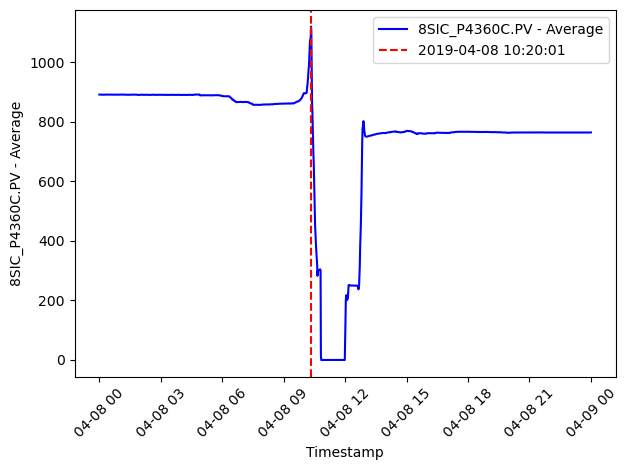

In [23]:
## 이상시점 2019-04-08 10시 20분 경 
sns.lineplot(data=df_d[(df_d['Timestamp'] > '2019-04-08 00:00:00') & (df_d['Timestamp'] < '2019-04-09 12:00:00')],
             x='Timestamp', y='8SIC_P4360C.PV - Average', label='8SIC_P4360C.PV - Average', color='blue')

plt.axvline(pd.to_datetime('2019-04-08 10:20:01'), color='red', linestyle='--', label='2019-04-08 10:20:01')
plt.xticks(rotation =45)
plt.tight_layout()
plt.legend()
plt.show()

**교차상관분석**
* 분석기간: 이상이 발생한 일주일 전 시점인 2019-04-01 10:20:01부터
* 중합공정의 사이클을 하루로 가정함. 최대 lag 값을 2880로 이틀만 고려함. 
* 교차상관관계가 가장 높은 10개의 변수와 그 때의 lag 값 출력

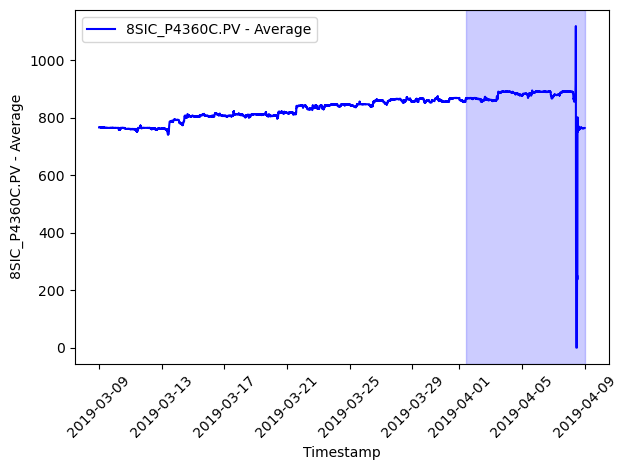

c:\Users\USER\DS\Miniconda\envs\ls_env\Lib\site-packages\statsmodels\tsa\stattools.py:1168: RuntimeWarning: invalid value encountered in divide
  ret = cvf / (np.std(x) * np.std(y))


Variable  Max Cross-correlation  Lag at Max
216   8II_P4360C.PV - Average               0.909664           2
222   8PI_P4361C.PV - Average               0.877775           5
224   8PI_P4362C.PV - Average               0.877576           5
217   8II_P4360D.PV - Average               0.814898           0
220   8TI_P4361C.PV - Average               0.784837          27
229   8FIC_P4350.PV - Average               0.729616           0
257   8TI_D9210C.PV - Average               0.677865        1074
218   8PI_P4360C.PV - Average               0.647860           2
215   8TI_P4360D.PV - Average               0.641143           0
404  LAB_8CHIP_COOH - Average               0.577202         263

In [24]:
# 분석기간 일주일
filtered_df_d = df_d[df_d['Timestamp'] >= '2019-04-01 10:20:01']

sns.lineplot(data=df_d, x='Timestamp', y='8SIC_P4360C.PV - Average', label='8SIC_P4360C.PV - Average', color='blue')
highlight_start = pd.to_datetime('2019-04-01 10:20:01')
highlight_end = filtered_df_d['Timestamp'].max()
plt.axvspan(highlight_start, highlight_end, color='blue', alpha=0.2)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
filtered_df_d = df_d[df_d['Timestamp'] >= '2019-04-01 10:20:01']


# 교차상관분석 함수
def calculate_top_cross_correlations(df, target_column, max_lags=2880, top_n=20):
    # 데이터 프레임에서 타겟 변수 선택
    target = df[target_column]

    # 결과를 저장할 리스트 초기화
    cross_correlations = []

    # DataFrame의 모든 컬럼을 순회하면서 타겟 변수와의 교차상관 계산
    for column in df.columns:
        if column != target_column:  # 타겟 변수 제외
            # 교차상관 계산 (타겟 변수가 먼저, 다른 변수들이 lag됨)
            cc = sm.tsa.stattools.ccf(target, df[column], adjusted=False)[:max_lags]
            max_cc = np.max(np.abs(cc))  # 최대 상관계수(절대값) 추출
            lag_at_max = np.argmax(np.abs(cc))  # 최대값이 발생하는 lag (양수 lag)
            # 각 결과 저장
            cross_correlations.append((column, max_cc, lag_at_max))

    # 결과를 데이터 프레임으로 변환
    cc_df = pd.DataFrame(cross_correlations, columns=['Variable', 'Max Cross-correlation', 'Lag at Max'])

    # 상관계수가 높은 상위 N개 결과 정렬 및 선택
    top_results = cc_df.sort_values(by='Max Cross-correlation', ascending=False).head(top_n)

    return top_results

# 함수 사용 예시
d_top_10 = calculate_top_cross_correlations(filtered_df_d, '8SIC_P4360C.PV - Average', max_lags=2880, top_n=10)
d_top_10


교차상관관계 top10 변수 중 Lag at Max > 0인 변수 시각화

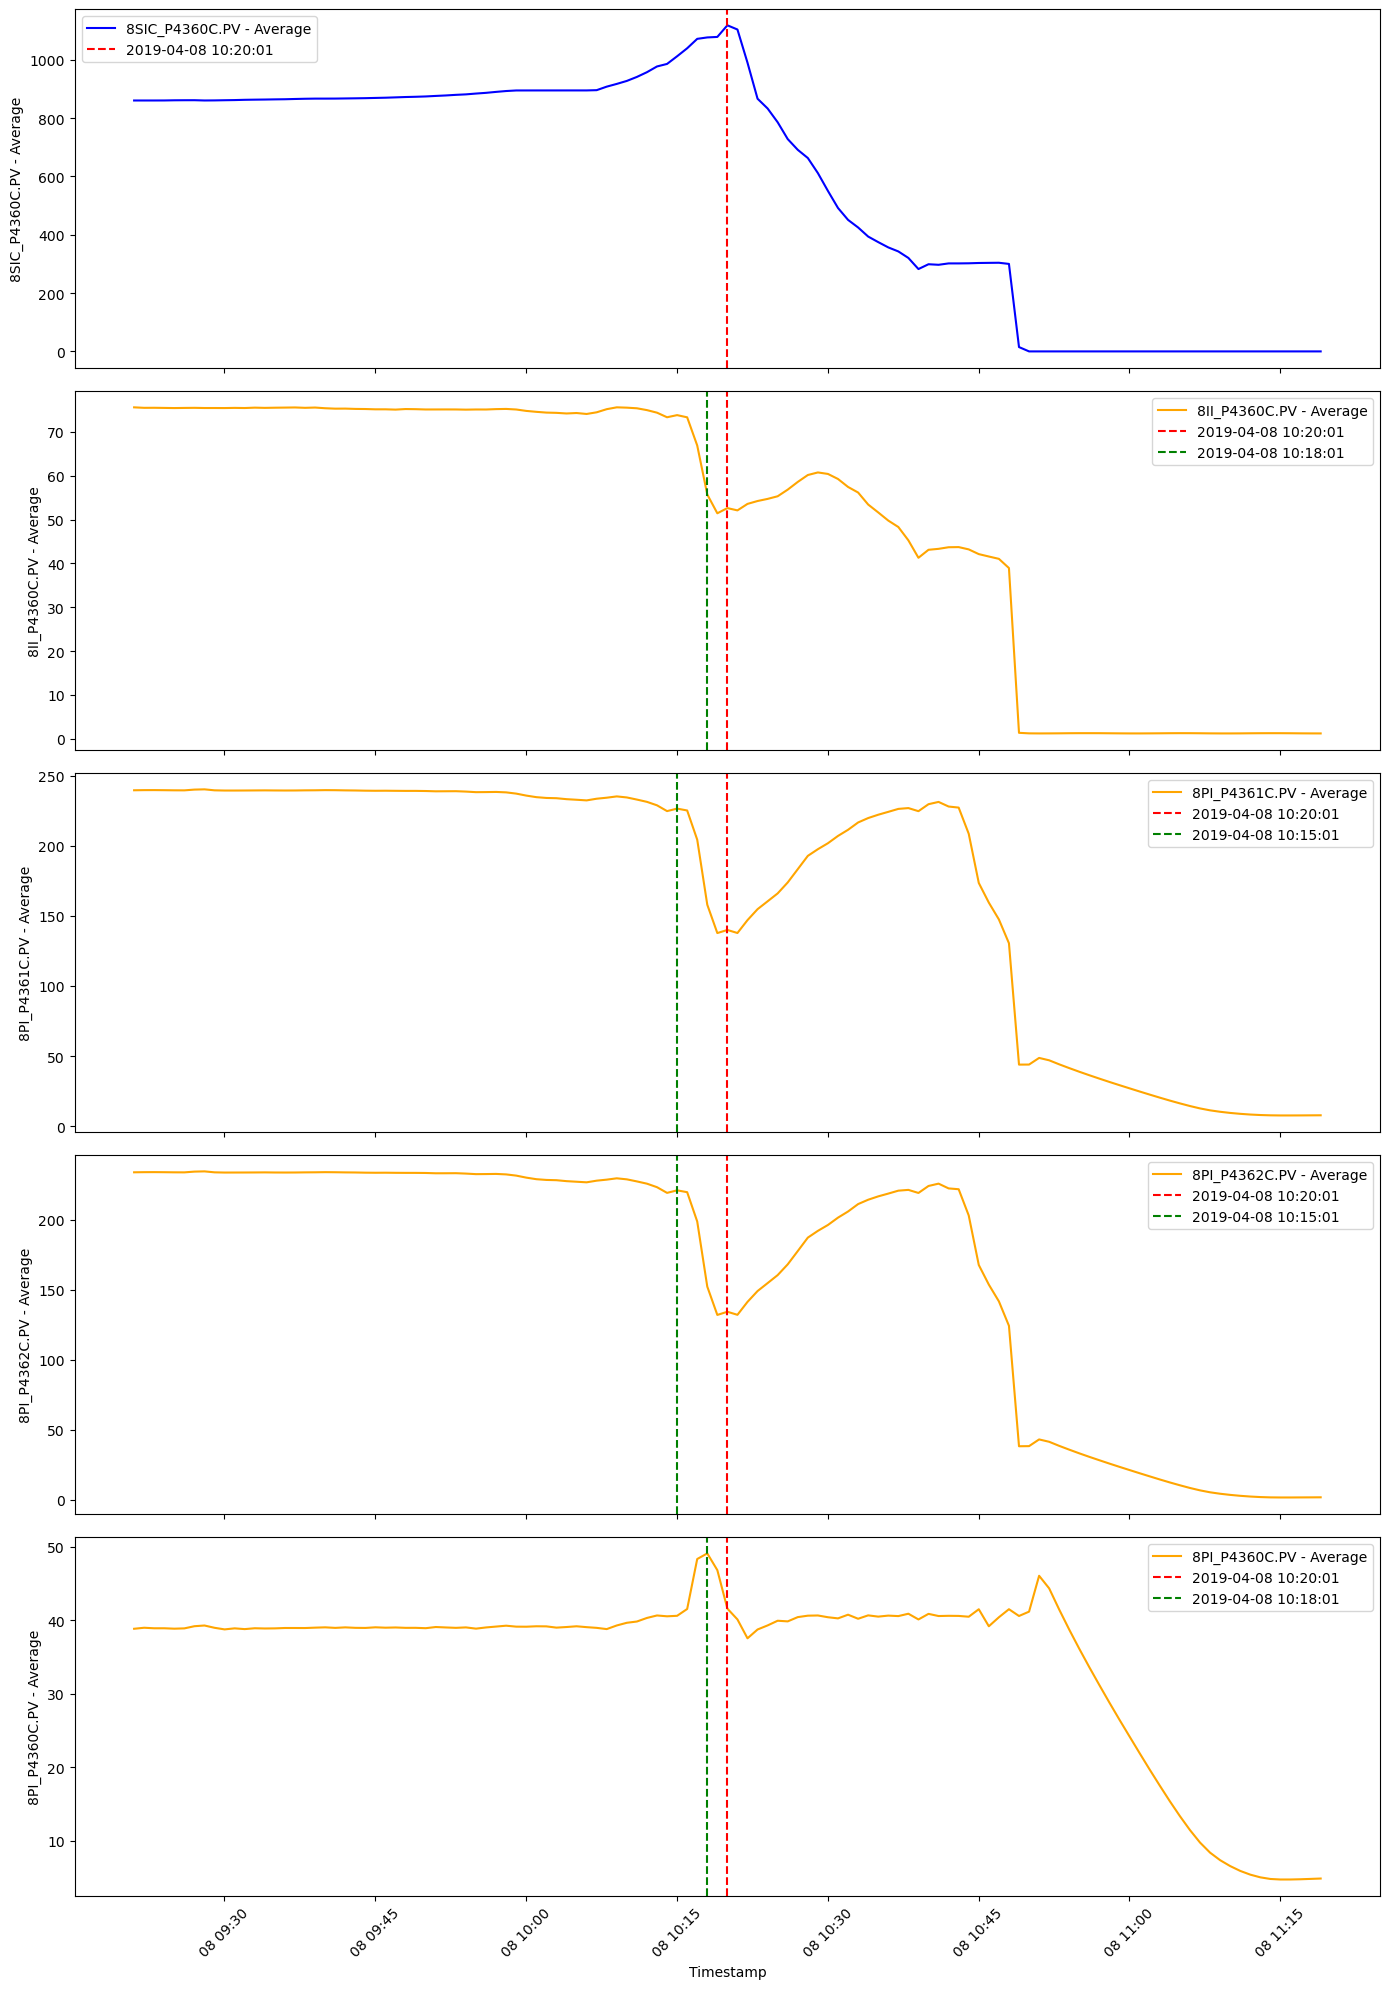

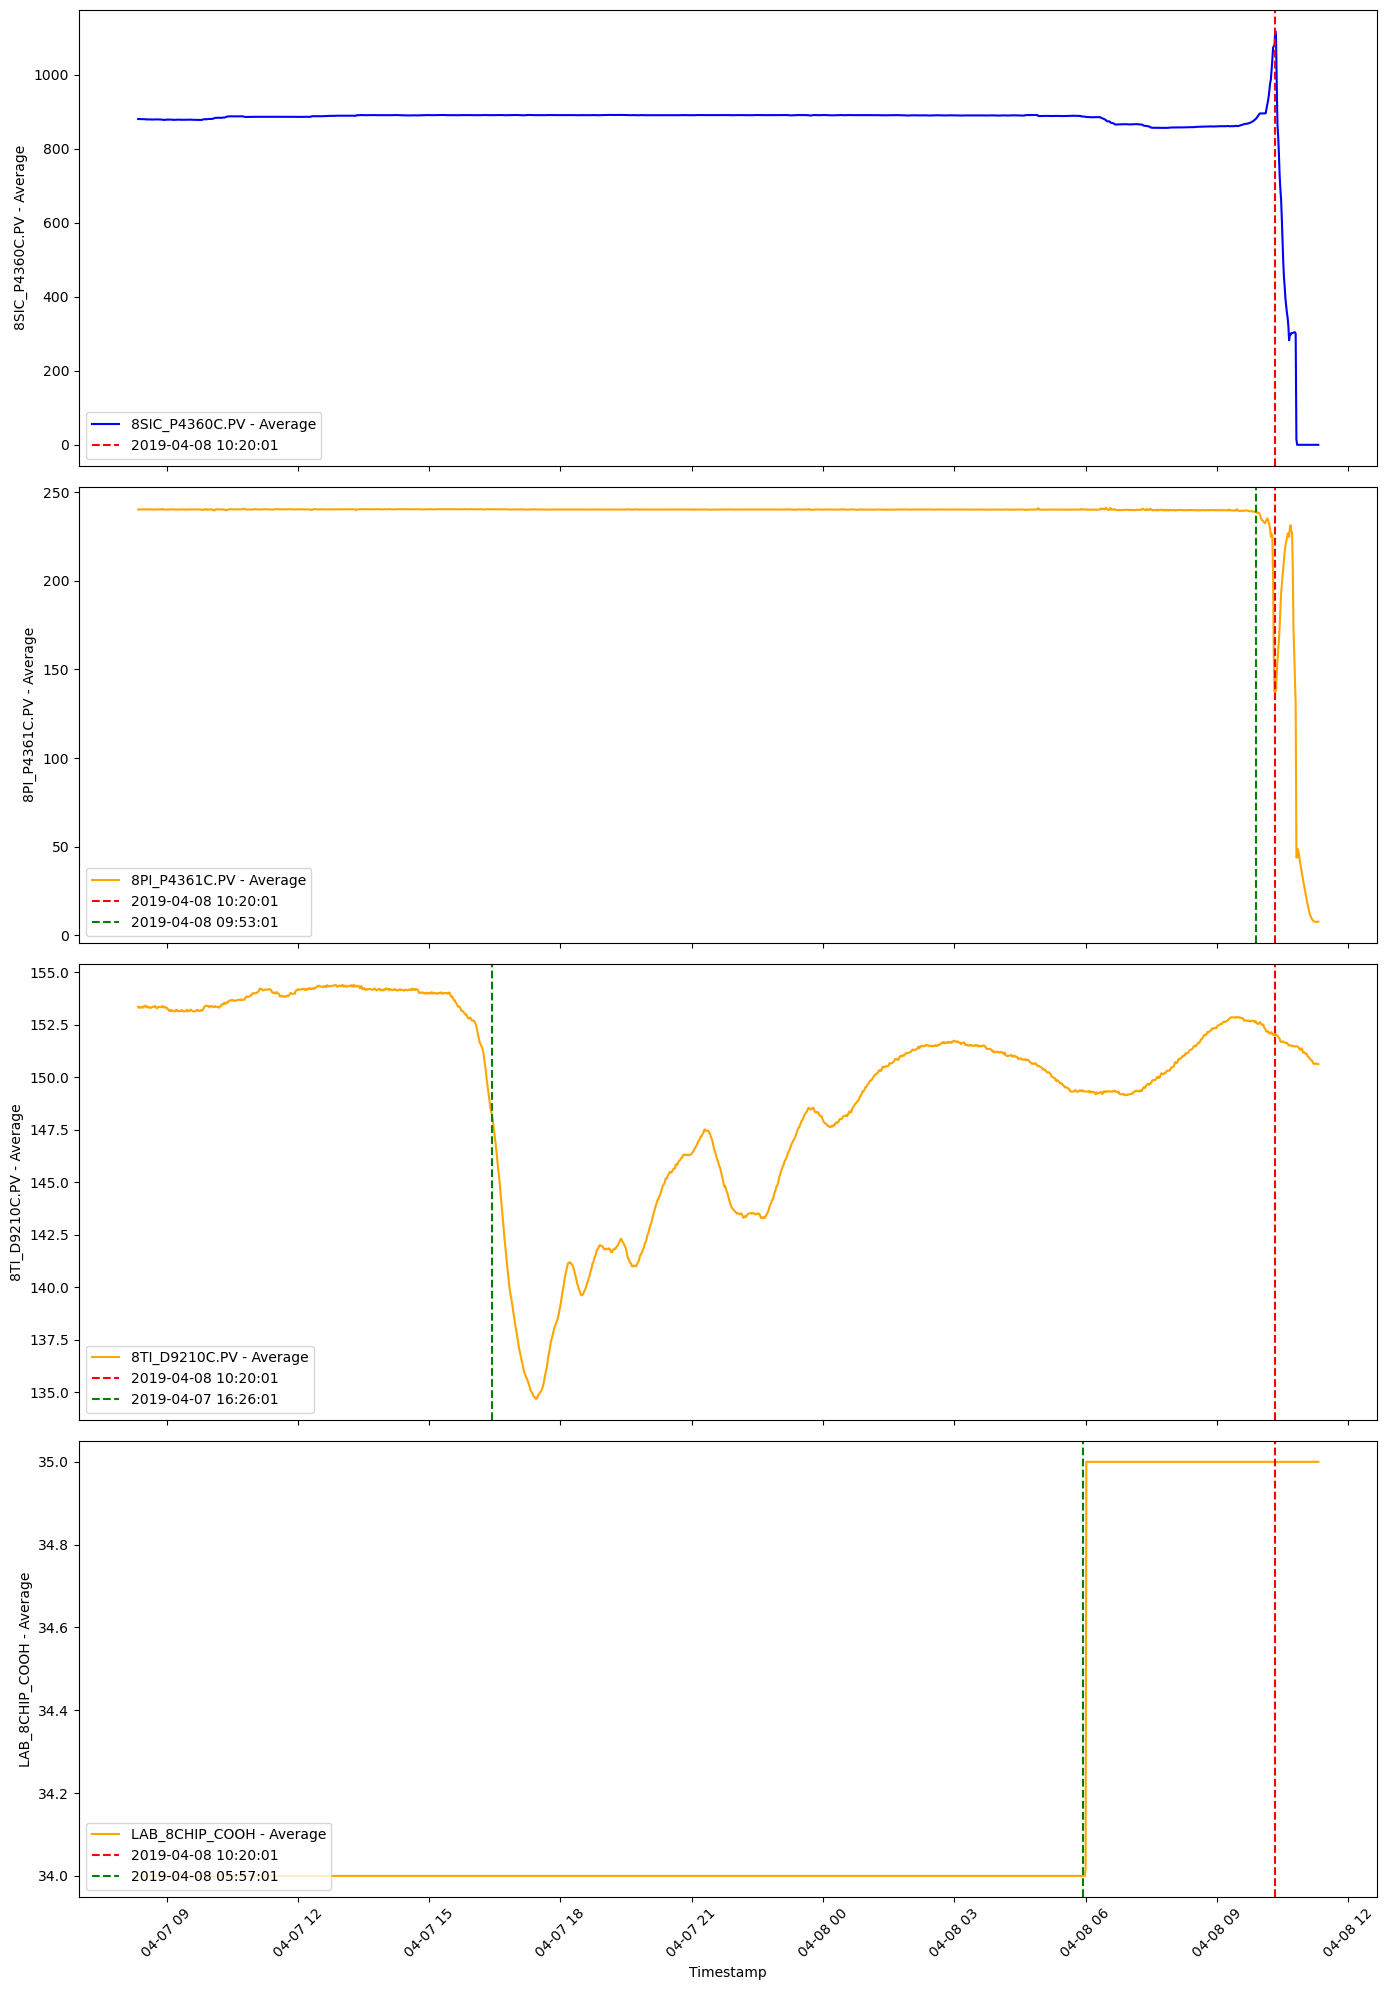

In [25]:
# 서브플롯 생성
fig, axes = plt.subplots(5, 1, figsize=(14, 20), sharex=True)

# 8SIC_P4360C.PV - Average 그래프
sns.lineplot(data=df_d[(df_d['Timestamp'] > '2019-04-08 09:20:01') & (df_d['Timestamp'] < '2019-04-08 11:20:01')],
 x='Timestamp', y='8SIC_P4360C.PV - Average', ax=axes[0], color='blue', label='8SIC_P4360C.PV - Average')
axes[0].axvline(pd.to_datetime('2019-04-08 10:20:01'), color='red', linestyle='--', label='2019-04-08 10:20:01')
axes[0].set_ylabel('8SIC_P4360C.PV - Average')
axes[0].legend(loc='upper left')

# 8II_P4360C.PV - Average 그래프
sns.lineplot(data=df_d[(df_d['Timestamp'] > '2019-04-08 09:20:01') & (df_d['Timestamp'] < '2019-04-08 11:20:01')],
 x='Timestamp', y='8II_P4360C.PV - Average', ax=axes[1], color='orange', label='8II_P4360C.PV - Average')
axes[1].axvline(pd.to_datetime('2019-04-08 10:20:01'), color='red', linestyle='--', label='2019-04-08 10:20:01')
axes[1].axvline(pd.to_datetime('2019-04-08 10:18:01'), color='green', linestyle='--', label='2019-04-08 10:18:01')
axes[1].set_ylabel('8II_P4360C.PV - Average')
axes[1].legend(loc='upper right')

# 8PI_P4361C.PV - Average 그래프
sns.lineplot(data=df_d[(df_d['Timestamp'] > '2019-04-08 09:20:01') & (df_d['Timestamp'] < '2019-04-08 11:20:01')],
 x='Timestamp', y='8PI_P4361C.PV - Average', ax=axes[2], color='orange', label='8PI_P4361C.PV - Average')
axes[2].axvline(pd.to_datetime('2019-04-08 10:20:01'), color='red', linestyle='--', label='2019-04-08 10:20:01')
axes[2].axvline(pd.to_datetime('2019-04-08 10:15:01'), color='green', linestyle='--', label='2019-04-08 10:15:01')
axes[2].set_ylabel('8PI_P4361C.PV - Average')
axes[2].legend(loc='upper right')

# 8PI_P4362C.PV - Average 그래프
sns.lineplot(data=df_d[(df_d['Timestamp'] > '2019-04-08 09:20:01') & (df_d['Timestamp'] < '2019-04-08 11:20:01')],
 x='Timestamp', y='8PI_P4362C.PV - Average', ax=axes[3], color='orange', label='8PI_P4362C.PV - Average')
axes[3].axvline(pd.to_datetime('2019-04-08 10:20:01'), color='red', linestyle='--', label='2019-04-08 10:20:01')
axes[3].axvline(pd.to_datetime('2019-04-08 10:15:01'), color='green', linestyle='--', label='2019-04-08 10:15:01')
axes[3].set_ylabel('8PI_P4362C.PV - Average')
axes[3].legend(loc='upper right')

# 8PI_P4360C.PV - Average 그래프
sns.lineplot(data=df_d[(df_d['Timestamp'] > '2019-04-08 09:20:01') & (df_d['Timestamp'] < '2019-04-08 11:20:01')],
 x='Timestamp', y='8PI_P4360C.PV - Average', ax=axes[4], color='orange', label='8PI_P4360C.PV - Average')
axes[4].axvline(pd.to_datetime('2019-04-08 10:20:01'), color='red', linestyle='--', label='2019-04-08 10:20:01')
axes[4].axvline(pd.to_datetime('2019-04-08 10:18:01'), color='green', linestyle='--', label='2019-04-08 10:18:01')
axes[4].set_ylabel('8PI_P4360C.PV - Average')
axes[4].legend(loc='upper right')

# 공통 설정
axes[-1].set_xlabel('Timestamp')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()





# 서브플롯 생성
fig, axes = plt.subplots(4, 1, figsize=(14, 20), sharex=True)

# 8SIC_P4360C.PV - Average 그래프
sns.lineplot(data=df_d[(df_d['Timestamp'] > '2019-04-07 08:20:01') & (df_d['Timestamp'] < '2019-04-08 11:20:01')],
 x='Timestamp', y='8SIC_P4360C.PV - Average', ax=axes[0], color='blue', label='8SIC_P4360C.PV - Average')
axes[0].axvline(pd.to_datetime('2019-04-08 10:20:01'), color='red', linestyle='--', label='2019-04-08 10:20:01')
axes[0].set_ylabel('8SIC_P4360C.PV - Average')
axes[0].legend(loc='lower left')

# 8PI_P4361C.PV - Average 그래프
sns.lineplot(data=df_d[(df_d['Timestamp'] > '2019-04-07 08:20:01') & (df_d['Timestamp'] < '2019-04-08 11:20:01')],
 x='Timestamp', y='8PI_P4361C.PV - Average', ax=axes[1], color='orange', label='8PI_P4361C.PV - Average')
axes[1].axvline(pd.to_datetime('2019-04-08 10:20:01'), color='red', linestyle='--', label='2019-04-08 10:20:01')
axes[1].axvline(pd.to_datetime('2019-04-08 09:53:01'), color='green', linestyle='--', label='2019-04-08 09:53:01')
axes[1].set_ylabel('8PI_P4361C.PV - Average')
axes[1].legend(loc='lower left')

# 8TI_D9210C.PV - Average 그래프
sns.lineplot(data=df_d[(df_d['Timestamp'] > '2019-04-07 08:20:01') & (df_d['Timestamp'] < '2019-04-08 11:20:01')],
 x='Timestamp', y='8TI_D9210C.PV - Average', ax=axes[2], color='orange', label='8TI_D9210C.PV - Average')
axes[2].axvline(pd.to_datetime('2019-04-08 10:20:01'), color='red', linestyle='--', label='2019-04-08 10:20:01')
axes[2].axvline(pd.to_datetime('2019-04-07 16:26:01'), color='green', linestyle='--', label='2019-04-07 16:26:01')
axes[2].set_ylabel('8TI_D9210C.PV - Average')
axes[2].legend(loc='lower left')

# LAB_8CHIP_COOH - Average 그래프
sns.lineplot(data=df_d[(df_d['Timestamp'] > '2019-04-07 08:20:01') & (df_d['Timestamp'] < '2019-04-08 11:20:01')],
 x='Timestamp', y='LAB_8CHIP_COOH - Average', ax=axes[3], color='orange', label='LAB_8CHIP_COOH - Average')
axes[3].axvline(pd.to_datetime('2019-04-08 10:20:01'), color='red', linestyle='--', label='2019-04-08 10:20:01')
axes[3].axvline(pd.to_datetime('2019-04-08 05:57:01'), color='green', linestyle='--', label='2019-04-08 05:57:01')
axes[3].set_ylabel('LAB_8CHIP_COOH - Average')
axes[3].legend(loc='lower left')

# 공통 설정
axes[-1].set_xlabel('Timestamp')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

이상 발생 시점 시각화

In [ ]:
# 새로운 변수 정보 (Lag at Max가 2부터 시작하는 표 기반)
d_variables_info = [
    {"Variable": "8II_P4360C.PV - Average", "Lag at Max": 2},
    {"Variable": "8PI_P4361C.PV - Average", "Lag at Max": 5},
    {"Variable": "8PI_P4362C.PV - Average", "Lag at Max": 5},
    {"Variable": "8II_P4360D.PV - Average", "Lag at Max": 0},
    {"Variable": "8TI_P4361C.PV - Average", "Lag at Max": 27},
    {"Variable": "8FIC_P4350.PV - Average", "Lag at Max": 0},
    {"Variable": "8TI_D9210C.PV - Average", "Lag at Max": 1074},
    {"Variable": "8PI_P4360C.PV - Average", "Lag at Max": 2},
    {"Variable": "8TI_P4360D.PV - Average", "Lag at Max": 0},
    {"Variable": "LAB_8CHIP_COOH - Average", "Lag at Max": 263}
]

#### Shifted 
# 데이터프레임 복사 및 lag 적용
df_d_shifted = filtered_df_d.copy()
for info in d_variables_info:
    variable = info["Variable"]
    lag = info["Lag at Max"]
    df_d_shifted[f"{variable}_lagged"] = df_d_shifted[variable].shift(lag)

# NaN 값 제거 (Shift로 인해 생긴 NaN)
df_d_shifted_drop = df_d_shifted.dropna()

# 타겟 변수 설정
d_X = df_d_shifted_drop[[f"{info['Variable']}_lagged" for info in d_variables_info]]
d_y = df_d_shifted_drop['8SIC_P4360C.PV - Average']


# 상수항 추가 (회귀 모델에 절편 포함)
d_X = sm.add_constant(d_X)

# 회귀 모델 적합
model = sm.OLS(d_y, d_X).fit()

# 모델 요약 및 p-value 확인
print("\nShift 적용 데이터 회귀 결과:")
print(model.summary())


Shift 적용 데이터 회귀 결과:
                               OLS Regression Results                               
Dep. Variable:     8SIC_P4360C.PV - Average   R-squared:                       0.981
Model:                                  OLS   Adj. R-squared:                  0.981
Method:                       Least Squares   F-statistic:                 5.013e+04
Date:                      Tue, 05 Nov 2024   Prob (F-statistic):               0.00
Time:                              10:23:13   Log-Likelihood:                -39187.
No. Observations:                      9827   AIC:                         7.840e+04
Df Residuals:                          9816   BIC:                         7.847e+04
Df Model:                                10                                         
Covariance Type:                  nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

다중공선성 확인
* 모든 변수의 VIF가 10이상으로 높음. 
* 단순회귀분석 실시하기로 함. 

In [27]:
d_X_vif = sm.add_constant(d_X)  # 상수 포함
vif_data = pd.DataFrame()
vif_data["Variable"] = d_X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(d_X_vif.values, i) for i in range(d_X_vif.shape[1])]
vif_data

Variable           VIF
0                             const  1.975505e+06
1    8II_P4360C.PV - Average_lagged  2.843617e+01
2    8PI_P4361C.PV - Average_lagged  2.177590e+04
3    8PI_P4362C.PV - Average_lagged  2.150784e+04
4    8II_P4360D.PV - Average_lagged  7.847393e+00
5    8TI_P4361C.PV - Average_lagged  5.905673e+00
6    8FIC_P4350.PV - Average_lagged  1.099671e+01
7    8TI_D9210C.PV - Average_lagged  2.166982e+00
8    8PI_P4360C.PV - Average_lagged  4.382983e+00
9    8TI_P4360D.PV - Average_lagged  8.727296e+01
10  LAB_8CHIP_COOH - Average_lagged  7.672791e+01

**단순회귀분석**
* p-value가 충분히 낮으므로 10개의 변수들이 타겟변수들에 대해 통계적으로 유의미하게 영향을 미치는 것을 확인할 수 있음

In [32]:
# 각 변수에 대해 단순 회귀 수행 및 결과 저장
results = []
for info in d_variables_info:
    variable_name = f"{info['Variable']}_lagged"
    d_X = df_d_shifted[[variable_name]]
    d_X = sm.add_constant(d_X)  # 상수항 추가
    d_y = df_d_shifted['8SIC_P4360C.PV - Average']

    # 단순 회귀 모델 적합
    model = sm.OLS(d_y, d_X, missing='drop').fit()
    
    # 결과 저장
    results.append({
        "Variable": variable_name,
        "Coefficient": model.params[variable_name],
        "p-value": model.pvalues[variable_name],
        "R-squared": model.rsquared
    })

# 결과를 데이터프레임으로 정리
results_df = pd.DataFrame(results)
results_df


Variable  Coefficient  p-value  R-squared
0   8II_P4360C.PV - Average_lagged    11.914452      0.0   0.827507
1   8PI_P4361C.PV - Average_lagged     3.972872      0.0   0.770495
2   8PI_P4362C.PV - Average_lagged     3.982560      0.0   0.770145
3   8II_P4360D.PV - Average_lagged   -73.222887      0.0   0.664059
4   8TI_P4361C.PV - Average_lagged   -32.427308      0.0   0.615975
5   8FIC_P4350.PV - Average_lagged   406.993846      0.0   0.532339
6   8TI_D9210C.PV - Average_lagged    25.629911      0.0   0.469313
7   8PI_P4360C.PV - Average_lagged    23.370604      0.0   0.419732
8   8TI_P4360D.PV - Average_lagged     6.283236      0.0   0.411065
9  LAB_8CHIP_COOH - Average_lagged  -222.892766      0.0   0.429981